# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [41]:
# Import libraries
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, \
                                  avg, from_unixtime, split, min, max, round, lit, mean
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

#from pyspark.sql.types import IntegerType, TimestampType
import datetime
from pyspark.sql.functions import to_date, year, month, dayofmonth, dayofweek, hour, date_format, substring

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

In [42]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [43]:
# Set time parser policy
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

### Common Functions

In [4]:
# Set plot's figure size
def set_plot_size(width, height):
    return plt.figure(figsize = [width, height]);

def get_user_logs(userId, sessionId=None):
    if sessionId == None:
        return data.where(data.userId == userId) \
            .select('tsDate', 'userId', 'sessionId', 'itemInSession', 'level', 'page') \
            .sort('tsDate', 'itemInSession')
    else:
        return data.where((data.userId == userId) & (data.sessionId == sessionId)) \
            .select('tsDate', 'userId', 'sessionId', 'itemInSession', 'level', 'page') \
            .sort('tsDate', 'itemInSession')

# Load and prepare Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [46]:
data.where(data.churn == 1).select('userId').dropDuplicates().count()

67

In [104]:
# Load dataset
path = "data/mini_sparkify_event_data.json"
data = spark.read.json(path)
original_count = data.count()

# Remove rows with missing users
data = data.where(~((col('userId').isNull()) | (col('userId') == '')))

# Exclude non-relevant columns
data = data.drop('firstName')
data = data.drop('lastName')
#data = data.drop('method')

data = data.withColumn('regDate', (col('registration') / 1000.0).cast(TimestampType()))
data = data.withColumn('tsDate', (col('ts') / 1000.0).cast(TimestampType()))
data.take(1)

data = data.withColumn('city', split(data['location'], ',')[0])
data = data.withColumn('state', split(data['location'], ',')[1])
data = data.drop('location')

# Define churned users using Cancellation Confirmation event (canceled)
query_churn_by_cc = data.where(data.page == 'Cancellation Confirmation')
print(f'Churned users who cancelled subscription: {query_churn_by_cc.count()}')

# Label churned (canceled) users
canceled = query_churn_by_cc.select('userId').dropDuplicates().select('userId')
canceled_uids = [row.userId for row in canceled.collect()];
set_churn = udf(lambda x: 1 if x in canceled_uids else 0, IntegerType())
data = data.withColumn('churn', set_churn('userId'))

# Add [userRowId] column that assigns a 1-based index to every user's log ordered by [ts]
w =  Window.partitionBy(data.userId).orderBy('ts', 'itemInSession')
data = data.withColumn('userRowId', row_number().over(w))

# Add [userRowDescId] column that assigns a 1-based index to every user's log ordered by [ts] descending.
w =  Window.partitionBy(data.userId).orderBy(col('ts').desc(), col('itemInSession').desc())
data = data.withColumn('userRowDescId', row_number().over(w))

# Add last level column
last_levels = dict()
for row in data.where(data.userRowDescId == 1).select('userId', 'level').collect():
    last_levels[row.userId] = row.level
get_level = udf(lambda userId: last_levels[userId])
data = data.withColumn('lastLevel', get_level('userId'))

Churned users who cancelled subscription: 52


In [ ]:
# Label downgraded (non-canceled) users
canceled = query_churn_by_cc.select('userId').dropDuplicates().select('userId')
canceled_uids = [row.userId for row in canceled.collect()];
set_churn = udf(lambda x: 1 if x in canceled_uids else 0, IntegerType())
data = data.withColumn('churn', set_churn('userId'))

In [305]:
# Label canceled users
canceled = query_churn_by_cc.select('userId').dropDuplicates().select('userId')
canceled_uids = [row.userId for row in canceled.collect()];
set_churn = udf(lambda x: 1 if x in canceled_uids else 0, IntegerType())
data = data.withColumn('canceled', set_churn('userId'))

In [311]:
set_churn = udf(lambda x: x)
data = data.withColumn('churn', set_churn('canceled'))
data.take(1)

[Row(artist=None, auth='Logged In', gender='F', itemInSession=34, length=None, level='free', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', regDate=datetime.datetime(2018, 9, 27, 4, 45, 40), tsDate=datetime.datetime(2018, 11, 21, 19, 12, 32), city='Bridgeport-Stamford-Norwalk', state=' CT', churn='0', userRowId=381, userRowDescId=1, lastLevel='free', downgraded=0, downgrade=0, canceled=0)]

In [312]:
data.where(data.churn == 1).select('userId').dropDuplicates().count()

52

In [325]:
# Query churned users by downgrade event
# Note: we fusion both types of churned users - canceled + downgraded
churned2 = data.where((data.churn == 1) \
           | ((data.page == 'Submit Downgrade') \
           & (data.lastLevel == 'free'))) \
    .select('userId') \
    .dropDuplicates()

# downgraded only
downgraded = data.where((data.page == 'Submit Downgrade') \
           & (data.lastLevel == 'free')) \
    .select('userId') \
    .dropDuplicates()

# Label churned users
uids = [row.userId for row in churned2.collect()]
set_churn = udf(lambda userId: 1 if userId in uids else 0, IntegerType())
data = data.withColumn('churn', set_churn('userId')) \

# Label downgraded users (churn=1)
uids = [row.userId for row in downgraded.collect()]
set_downgrade = udf(lambda userId: 1 if userId in uids else 0, IntegerType())
data = data.withColumn('downgraded', set_downgrade('userId')) \
    
data.printSchema()
data.take(3)

# check count of churned users
data.where(data.churn == 1).select('userId').dropDuplicates().count()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- regDate: timestamp (nullable = true)
 |-- tsDate: timestamp (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- userRowId: integer (nullable = true)
 |-- userRowDescId: integer (nullable = true)
 |-- lastLevel: string (nullable = true)
 |-- downgraded: integer (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- canceled: inte

67

In [122]:
# downgraded only
data.where(data.page == 'Downgrade').select('userId').dropDuplicates().count()

154

In [106]:
data.where(data.downgraded == 1).select('userId').dropDuplicates().count()

20

#### Add churn groups totals

In [40]:
data = data.drop('total')
data = data.drop('total2')
data.take(1)

[Row(artist=None, auth='Logged In', gender='F', itemInSession=34, length=None, level='free', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', regDate=datetime.datetime(2018, 9, 27, 4, 45, 40), tsDate=datetime.datetime(2018, 11, 21, 19, 12, 32), city='Bridgeport-Stamford-Norwalk', state=' CT', churn=0, userRowId=381, userRowDescId=1, lastLevel='free', churn2=0)]

In [425]:
# Add user totals of each churn group to our dataframe
count0, count1, count20, count21 = 173, 52, 158, 67
get_churn_total = udf(lambda x: count0 if x == 0 else count1)
get_churn_total2 = udf(lambda x: count20 if x == 0 else count21)

data = data \
    .withColumn('total', get_churn_total('churn')) \
    .withColumn('total2', get_churn_total2('churn2'))
data.take(1)

[Row(artist=None, auth='Logged In', gender='F', itemInSession=34, length=None, level='free', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', regDate=datetime.datetime(2018, 9, 27, 4, 45, 40), tsDate=datetime.datetime(2018, 11, 21, 19, 12, 32), city='Bridgeport-Stamford-Norwalk', state=' CT', churn=0, userRowId=381, userRowDescId=1, lastLevel='free', churn2=0, total='173', total2='158')]

# Feature Testing

In [51]:
users = data.select('churn', 'userId').dropDuplicates()

### Average event length (*AvgEventLength*)

In [52]:
total_event_length = data \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000).alias('SessionLength')) \
    .groupby('userId') \
    .agg(Fsum('SessionLength').alias('TotalEventLength'))

total_event_count = data \
    .groupby('userId') \
    .agg(count('userId').alias('TotalEventCount'))


In [53]:
users.join(total_event_length, 'userId') \
    .join(total_event_count, 'userId') \
    .groupby('churn') \
    .agg(avg(col('TotalEventLength')/col('TotalEventCount')).alias('AvgEventLength')) \
    .show()

+-----+------------------+
|churn|    AvgEventLength|
+-----+------------------+
|    1|193.28687885812568|
|    0|  201.476129740567|
+-----+------------------+



In [57]:
total_nonsong_event_count = data \
    .where(data.page != 'NextSong') \
    .groupby('userId') \
    .agg(count('userId').alias('TotalNonSongEventCount'))


In [58]:
users.join(total_event_length, 'userId') \
    .join(total_nonsong_event_count, 'userId') \
    .groupby('churn') \
    .agg(avg(col('TotalEventLength')/col('TotalNonSongEventCount')).alias('AvgNonSongEventLength')) \
    .show()

+-----+---------------------+
|churn|AvgNonSongEventLength|
+-----+---------------------+
|    1|    948.4020027789409|
|    0|   1078.2956251731257|
+-----+---------------------+



In [ ]:
users.join(total_event_length, 'userId') \
    .join(total_nonsong_event_count, 'userId') \
    .groupby('churn') \
    .agg(avg(col('TotalEventLength')/col('TotalNonSongEventCount')).alias('AvgNonSongEventLength')) \

In [62]:
data.where(data.userId == 100017).select('tsDate', 'sessionId', 'page', 'level').show(100)

+-------------------+---------+--------------------+-----+
|             tsDate|sessionId|                page|level|
+-------------------+---------+--------------------+-----+
|2018-10-20 17:54:51|       17|            NextSong| free|
|2018-10-20 17:57:27|       17|            NextSong| free|
|2018-10-20 18:01:06|       17|            NextSong| free|
|2018-10-20 18:04:51|       17|            NextSong| free|
|2018-10-20 18:08:50|       17|            NextSong| free|
|2018-10-20 18:08:51|       17|         Thumbs Down| free|
|2018-10-20 18:11:21|       17|            NextSong| free|
|2018-10-20 18:15:39|       17|            NextSong| free|
|2018-10-20 18:20:02|       17|            NextSong| free|
|2018-10-20 18:20:20|       17|         Roll Advert| free|
|2018-10-20 18:23:54|       17|            NextSong| free|
|2018-10-20 18:28:31|       17|            NextSong| free|
|2018-10-20 18:28:52|       17|         Roll Advert| free|
|2018-10-20 18:31:40|       17|            NextSong| fre

In [59]:
948/1078

0.8794063079777366

In [65]:
data \
    .where(data.page != 'NextSong') \
    .groupby('churn', 'userId') \
    .agg(count('userId').alias('NonSongEventCount')) \
    .groupby('churn') \
    .agg(avg('NonSongEventCount').alias('AvgNonSongEventCount')) \
    .show()

+-----+--------------------+
|churn|AvgNonSongEventCount|
+-----+--------------------+
|    1|  195.38805970149255|
|    0|  235.38216560509554|
+-----+--------------------+



In [67]:
data \
    .where(data.page != 'NextSong') \
    .groupby('churn', 'userId') \
    .agg(count('userId').alias('NonSongEventCount')) \
    .select('NonSongEventCount') \
    .describe() \
    .show()

+-------+------------------+
|summary| NonSongEventCount|
+-------+------------------+
|  count|               224|
|   mean|223.41964285714286|
| stddev|227.03051446957588|
|    min|                 3|
|    max|              1630|
+-------+------------------+



In [69]:
data \
    .where(data.page != 'NextSong') \
    .where(data.churn == 1) \
    .groupby('userId') \
    .agg(count('userId').alias('NonSongEventCount')) \
    .select('NonSongEventCount') \
    .describe() \
    .show()

+-------+------------------+
|summary| NonSongEventCount|
+-------+------------------+
|  count|                67|
|   mean|195.38805970149255|
| stddev|192.63082569200665|
|    min|                 3|
|    max|              1285|
+-------+------------------+



In [70]:
data \
    .where(data.page != 'NextSong') \
    .where(data.churn == 0) \
    .groupby('userId') \
    .agg(count('userId').alias('NonSongEventCount')) \
    .select('NonSongEventCount') \
    .describe() \
    .show()

+-------+------------------+
|summary| NonSongEventCount|
+-------+------------------+
|  count|               157|
|   mean|235.38216560509554|
| stddev|239.79030729945543|
|    min|                 3|
|    max|              1630|
+-------+------------------+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [74]:
labels = data.select(col('churn').alias('label'), 'userId').dropDuplicates()

In [75]:
# feat 1: Gender [gen]
f_gen = data \
    .select('userId', 'gender') \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int').alias('gen'))

In [76]:
# feat 2: Last level [llevel]
f_llevel = data \
    .select('userId', 'lastLevel') \
    .dropDuplicates() \
    .replace(['free', 'paid'], ['0', '1'], 'lastLevel') \
    .select('userId', col('lastLevel').cast('int').alias('llevel'))

In [214]:
# feat 3: Log count [EventCount]
f_EventCount = data \
    .groupby('userId') \
    .agg(count('userId').alias('EventCount'))

In [215]:
# feat 4: Average session lengt [AvgSessionLength]
f_AvgSessionCount = data \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/60000).alias('duration')) \
    .groupby('userId') \
    .agg(avg('duration').alias('AvgSessionLength'))

In [216]:
# feat 5: Average Roll Advert page interactions [AvgRollAdvertCount]
f_AvgRollAdvertCount = data \
    .where(data.page == 'Roll Advert') \
    .groupby('userId') \
    .agg(count('userId').alias('AvgRollAdvertCount')) \
    .select('userId', 'AvgRollAdvertCount')

In [81]:
# feat 6: Average Upgrade page interactions [upgrade]
f_upgrade = data \
    .where(data.page == 'Upgrade') \
    .groupby('userId') \
    .agg(count('userId').alias('upgrade')) \
    .select('userId', 'upgrade')

#### User Interactions per hour

In [82]:
page_data = data.where(~data.page.isin(['Cancel', 'Cancellation Confirmation', 'Submit Downgrade']))

user_hours = page_data \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000/3600).alias('hours')) \
    .groupby('userId') \
    .agg(Fsum('hours').alias('hours'))
    
page_count_per_hour = page_data \
    .join(user_hours, 'userId', 'inner') \
    .groupby('page', 'userId', 'hours') \
    .agg((count('page')/col('hours')).alias('countPerHour'))

In [218]:
# feat 7: Average Roll Advert page interactions per hour [RollAdvertCountPerHour]
f_RollAdvertCountPerHour = page_count_per_hour.where(col('page') == 'Roll Advert') \
    .select('userId', col('countPerHour').alias('RollAdvertCountPerHour'))

In [287]:
# feat 8: Average Submit Upgrade page interactions per hour [subupgradeh]
f_SubmitUpgradeCountPerHour = page_count_per_hour.where(col('page') == 'Submit Upgrade') \
    .select('userId', col('countPerHour').alias('SubmitUpgradeCountPerHour'))

In [220]:
# feat 9: Average Thumbs Down page interactions per hour [ThumbsDownCountPerHour]
f_ThumbsDownCountPerHour = page_count_per_hour.where(col('page') == 'Thumbs Down') \
    .select('userId', col('countPerHour').alias('ThumbsDownCountPerHour'))

In [86]:
# feat 10: Average Upgrade page interactions per hour [upgradeh]
f_upgradeh = page_count_per_hour.where(col('page') == 'Upgrade') \
    .select('userId', col('countPerHour').alias('upgradeh'))

In [87]:
# feat 11: Average Settings page interactions per hour [settingsh]
f_settingsh = page_count_per_hour.where(col('page') == 'Settings') \
    .select('userId', col('countPerHour').alias('settingsh'))

In [88]:
# feat 12: Total song length [songlen]
f_songlen = data \
    .where(data.page == 'NextSong') \
    .select('userId', 'length') \
    .groupby('userId') \
    .agg(Fsum('length').alias('songlen'))

In [89]:
f_avgnonsongeventcount = data \
    .where(data.page != 'NextSong') \
    .groupby('userId') \
    .agg(count('userId').alias('NonSongEventCount'))

In [107]:
f_downgraded = data \
    .where(data.downgraded == 1) \
    .select('userId', col('downgraded').alias('Downgraded')) \
    .dropDuplicates()

In [123]:
# mark users who have interacted with Downgrade event at least once
downgrade_users = data \
    .where(data.page == 'Downgrade') \
    .select('userId') \
    .dropDuplicates()

# Label downgrade users
uids = [row.userId for row in downgrade_users.collect()]
set_downgrade = udf(lambda userId: 1 if userId in uids else 0, IntegerType())
data = data.withColumn('downgrade', set_downgrade('userId')) \

In [128]:
f_downgrade = data \
    .select('userId', col('downgrade').alias('Downgrade')) \
    .dropDuplicates()

In [195]:
f_label = data \
    .select('userId', col('churn').alias('flabel')) \
    .dropDuplicates()

In [243]:
totals = data \
    .where(data.page == 'NextSong') \
    .select('userId') \
    .groupby('userId') \
    .agg(count('userId').alias('total'))

f_UniqueSongShare = data \
    .where(data.page == 'NextSong') \
    .select('userId', 'song') \
    .dropDuplicates() \
    .groupby('userId') \
    .count() \
    .join(totals, on = ['userId'], how = 'inner') \
    .select('userId', (col('count')/col('total')).alias('UniqueSongShare')) 

In [283]:
f_UniqueSongCount = data \
    .where(data.page == 'NextSong') \
    .select('userId', 'song') \
    .dropDuplicates() \
    .groupby('userId') \
    .agg(count('userId').alias('UniqueSongCount'))

In [245]:
f_UniqueSongShare.show(225)

+------+------------------+
|userId|   UniqueSongShare|
+------+------------------+
|100010|0.9781818181818182|
|200002|0.9767441860465116|
|   125|               1.0|
|   124|0.8185829860259868|
|    51|0.8782567503552818|
|     7|0.9866666666666667|
|    15|0.8918495297805643|
|    54|0.8497008095740937|
|   155| 0.925609756097561|
|100014|0.9649805447470817|
|   132|0.8910788381742739|
|   154|0.9880952380952381|
|   101|0.8948247078464107|
|    11|0.9520865533230294|
|   138|0.8652173913043478|
|300017|0.8295704845814978|
|100021|0.9826086956521739|
|    29|0.8461030383091149|
|    69|0.9208888888888889|
|   112|0.9813953488372092|
|    42|0.8287153652392947|
|    73|0.9628647214854111|
|    87|0.9452411994784876|
|200010|0.9620253164556962|
|    64|               1.0|
|     3| 0.985981308411215|
|   113|0.9015772870662461|
|    30|0.8976711362032463|
|    34|               1.0|
|   133|               1.0|
|    59|0.9392265193370166|
|   139|0.9761273209549072|
|   146|0.9538461538

#### User Interactions per all user interactions (share)

In [292]:
totals = page_data.groupby('userId').agg(count('userId').alias('total'))

page_share = page_data \
    .groupby('userId', 'page') \
    .count() \
    .join(totals, on = ['userId'], how = 'inner') \
    .select('userId', 'page', (col('count')/col('total')).alias('share')) \

In [286]:
page_share.where(page_share.page == 'Submit Upgrade').select('share').describe().show()

+-------+--------------------+
|summary|               share|
+-------+--------------------+
|  count|                 131|
|   mean|0.001294754363153954|
| stddev|0.001775529797369...|
|    min|1.383317194632729...|
|    max|0.016666666666666666|
+-------+--------------------+



In [293]:
# feat 7: Average Roll Advert page interactions per hour [RollAdvertCountPerHour]
f_SubmitUpgradeShare = page_share.where(col('page') == 'Roll Advert') \
    .select('userId', col('share').alias('SubmitUpgradeShare'))

In [ ]:
# ALL FEATURES
# Combining all features with the target churn label
model_data  = labels.join(f_gen, 'userId', 'outer') \
    .join(f_llevel, 'userId', 'outer') \
    .join(f_nlog, 'userId', 'outer') \
    .join(f_seslen, 'userId', 'outer') \
    .join(f_advert, 'userId', 'outer') \
    .join(f_upgrade, 'userId', 'outer') \
    .join(f_adverth, 'userId', 'outer') \
    .join(f_submitupgradeh, 'userId', 'outer') \
    .join(f_thumbsdownh, 'userId', 'outer') \
    .join(f_upgradeh, 'userId', 'outer') \
    .join(f_settingsh, 'userId', 'outer') \
    .join(f_songlen, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [129]:
# SELECTED FEATURES
# Combining all features with the target churn label
model_data  = labels.join(f_gen, 'userId', 'outer') \
    .join(f_llevel, 'userId', 'outer') \
    .join(f_nlog, 'userId', 'outer') \
    .join(f_seslen, 'userId', 'outer') \
    .join(f_advert, 'userId', 'outer') \
    .join(f_upgrade, 'userId', 'outer') \
    .join(f_adverth, 'userId', 'outer') \
    .join(f_thumbsdownh, 'userId', 'outer') \
    .join(f_downgrade, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [141]:
# SELECTED FEATURES 2
# Combining all features with the target churn label
model_data  = labels.join(f_llevel, 'userId', 'outer') \
    .join(f_nlog, 'userId', 'outer') \
    .join(f_seslen, 'userId', 'outer') \
    .join(f_advert, 'userId', 'outer') \
    .join(f_upgrade, 'userId', 'outer') \
    .join(f_adverth, 'userId', 'outer') \
    .join(f_thumbsdownh, 'userId', 'outer') \
    .join(f_downgrade, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [152]:
# SELECTED FEATURES 3
model_data  = labels.join(f_llevel, 'userId', 'outer') \
    .join(f_nlog, 'userId', 'outer') \
    .join(f_seslen, 'userId', 'outer') \
    .join(f_advert, 'userId', 'outer') \
    .join(f_upgrade, 'userId', 'outer') \
    .join(f_adverth, 'userId', 'outer') \
    .join(f_submitupgradeh, 'userId', 'outer') \
    .join(f_thumbsdownh, 'userId', 'outer') \
    .join(f_upgradeh, 'userId', 'outer') \
    .join(f_downgrade, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [177]:
# SELECTED FEATURES 2b
# Combining all features with the target churn label
model_data  = labels.join(f_nlog, 'userId', 'outer') \
    .join(f_seslen, 'userId', 'outer') \
    .join(f_advert, 'userId', 'outer') \
    .join(f_adverth, 'userId', 'outer') \
    .join(f_thumbsdownh, 'userId', 'outer') \
    .join(f_downgrade, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [326]:
# SELECTED FEATURES - the best features
# Combining all features with the target churn label
model_data  = labels.join(f_EventCount, 'userId', 'outer') \
    .join(f_AvgSessionCount, 'userId', 'outer') \
    .join(f_AvgRollAdvertCount, 'userId', 'outer') \
    .join(f_RollAdvertCountPerHour, 'userId', 'outer') \
    .join(f_ThumbsDownCountPerHour, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [294]:
# SELECTED FEATURES - testing
# Combining all features with the target churn label
model_data  = labels.join(f_EventCount, 'userId', 'outer') \
    .join(f_AvgSessionCount, 'userId', 'outer') \
    .join(f_AvgRollAdvertCount, 'userId', 'outer') \
    .join(f_RollAdvertCountPerHour, 'userId', 'outer') \
    .join(f_ThumbsDownCountPerHour, 'userId', 'outer') \
    .join(f_SubmitUpgradeShare, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [327]:
# churn model
model_df = model_data.toPandas()

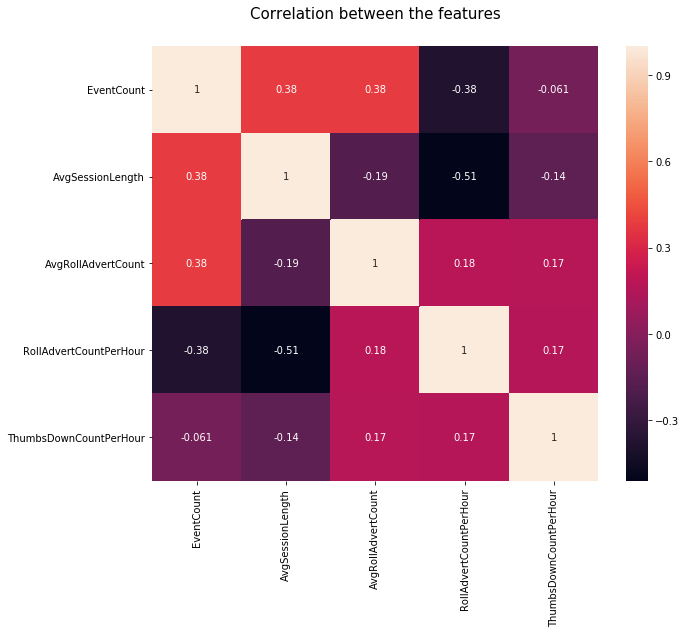

In [328]:
# correlation heatmap
plt.figure(figsize = [10, 8])
plt.title('Correlation between the features', y=1.05, size=15)
#ax = sb.heatmap(model_df.iloc[:, 1:].corr(), linewidths=0.1, vmax=1.0, square=True, annot=True);

ax = sb.heatmap(model_df.iloc[:, 1:].corr(), annot=True)
plt.yticks(rotation = 0)

# correct plot cut off (Note: we must fix it due to the bug in the matplotlib 3.1.1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [111]:
model_df.to_csv('data\\model_data.csv')

In [715]:
# ALL FEATURES
modelSchema = StructType([ \
                    StructField("label", IntegerType(), False) \
                    ,StructField("gen", IntegerType(), False) \
                    ,StructField("llevel", IntegerType(), False) \
                    ,StructField("nlog", IntegerType(), False) \
                    ,StructField("seslen", FloatType(), False) \
                    ,StructField("advert", IntegerType(), False) \
                    ,StructField("upgrade", IntegerType(), False) \
                    ,StructField("adverth", FloatType(), False) \
                    ,StructField("submitupgradeh", FloatType(), False) \
                    ,StructField("thumbsdownh", FloatType(), False) \
                    ,StructField("upgradeh", FloatType(), False) \
                    ,StructField("settingsh", FloatType(), False) \
                    ,StructField("songlen", FloatType(), False) \
                         ])
data2 = spark.createDataFrame(model_df, schema=modelSchema)
data2.printSchema()

root
 |-- label: integer (nullable = false)
 |-- gen: integer (nullable = false)
 |-- llevel: integer (nullable = false)
 |-- nlog: integer (nullable = false)
 |-- seslen: float (nullable = false)
 |-- advert: integer (nullable = false)
 |-- upgrade: integer (nullable = false)
 |-- adverth: float (nullable = false)
 |-- submitupgradeh: float (nullable = false)
 |-- thumbsdownh: float (nullable = false)
 |-- upgradeh: float (nullable = false)
 |-- settingsh: float (nullable = false)
 |-- songlen: float (nullable = false)



In [ ]:
# SELECTED FEATURES
modelSchema = StructType([ \
                    StructField("gen", IntegerType(), False) \
                    ,StructField("label", IntegerType(), False) \
                    ,StructField("llevel", IntegerType(), False) \
                    ,StructField("nlog", IntegerType(), False) \
                    ,StructField("seslen", FloatType(), False) \
                    ,StructField("advert", IntegerType(), False) \
                    ,StructField("upgrade", IntegerType(), False) \
                    ,StructField("adverth", FloatType(), False) \
                    ,StructField("thumbsdownh", FloatType(), False) \
                    ,StructField("Downgrade", IntegerType(), False) \
                         ])
data2 = spark.createDataFrame(model_df, schema=modelSchema)
data2.printSchema()

In [145]:
# SELECTED FEATURES 2
modelSchema = StructType([ \
                    StructField("label", IntegerType(), False) \
                    ,StructField("llevel", IntegerType(), False) \
                    ,StructField("nlog", IntegerType(), False) \
                    ,StructField("seslen", FloatType(), False) \
                    ,StructField("advert", IntegerType(), False) \
                    ,StructField("upgrade", IntegerType(), False) \
                    ,StructField("adverth", FloatType(), False) \
                    ,StructField("thumbsdownh", FloatType(), False) \
                    ,StructField("Downgrade", IntegerType(), False) \
                         ])
data2 = spark.createDataFrame(model_df, schema=modelSchema)
data2.printSchema()

root
 |-- label: integer (nullable = false)
 |-- llevel: integer (nullable = false)
 |-- nlog: integer (nullable = false)
 |-- seslen: float (nullable = false)
 |-- advert: integer (nullable = false)
 |-- upgrade: integer (nullable = false)
 |-- adverth: float (nullable = false)
 |-- thumbsdownh: float (nullable = false)
 |-- Downgrade: integer (nullable = false)



In [169]:
# SELECTED FEATURES 2b
modelSchema = StructType([ \
                    StructField("label", IntegerType(), False) \
                    ,StructField("nlog", IntegerType(), False) \
                    ,StructField("seslen", FloatType(), False) \
                    ,StructField("advert", IntegerType(), False) \
                    ,StructField("adverth", FloatType(), False) \
                    ,StructField("thumbsdownh", FloatType(), False) \
                    ,StructField("Downgrade", IntegerType(), False) \
                         ])
data2 = spark.createDataFrame(model_df, schema=modelSchema)
data2.printSchema()

root
 |-- label: integer (nullable = false)
 |-- nlog: integer (nullable = false)
 |-- seslen: float (nullable = false)
 |-- advert: integer (nullable = false)
 |-- adverth: float (nullable = false)
 |-- thumbsdownh: float (nullable = false)
 |-- Downgrade: integer (nullable = false)



In [181]:
# SELECTED FEATURES 2c
modelSchema = StructType([ \
                    StructField("label", IntegerType(), False) \
                    ,StructField("nlog", IntegerType(), False) \
                    ,StructField("seslen", FloatType(), False) \
                    ,StructField("advert", IntegerType(), False) \
                    ,StructField("adverth", FloatType(), False) \
                    ,StructField("thumbsdownh", FloatType(), False) \
                         ])
data2 = spark.createDataFrame(model_df, schema=modelSchema)
data2.printSchema()

root
 |-- label: integer (nullable = false)
 |-- nlog: integer (nullable = false)
 |-- seslen: float (nullable = false)
 |-- advert: integer (nullable = false)
 |-- adverth: float (nullable = false)
 |-- thumbsdownh: float (nullable = false)



In [251]:
# SELECTED FEATURES - testing

modelSchema = StructType([ \
                    StructField("label", IntegerType(), False) \
                    ,StructField("EventCount", IntegerType(), False) \
                    ,StructField("AvgSessionCount", FloatType(), False) \
                    ,StructField("AvgRollAdvertCount", IntegerType(), False) \
                    ,StructField("RollAdvertCountPerHour", FloatType(), False) \
                    ,StructField("ThumbsDownCountPerHour", FloatType(), False) \
                    ,StructField("UniqueSongShare", FloatType(), False) \
                         ])
data2 = spark.createDataFrame(model_df, schema=modelSchema)
data2.printSchema()

root
 |-- label: integer (nullable = false)
 |-- EventCount: integer (nullable = false)
 |-- AvgSessionCount: float (nullable = false)
 |-- AvgRollAdvertCount: integer (nullable = false)
 |-- RollAdvertCountPerHour: float (nullable = false)
 |-- ThumbsDownCountPerHour: float (nullable = false)
 |-- UniqueSongShare: float (nullable = false)



In [329]:
# SELECTED FEATURES - the best features

modelSchema = StructType([ \
                    StructField("label", IntegerType(), False) \
                    ,StructField("EventCount", IntegerType(), False) \
                    ,StructField("AvgSessionCount", FloatType(), False) \
                    ,StructField("AvgRollAdvertCount", IntegerType(), False) \
                    ,StructField("RollAdvertCountPerHour", FloatType(), False) \
                    ,StructField("ThumbsDownCountPerHour", FloatType(), False) \
                         ])
data2 = spark.createDataFrame(model_df, schema=modelSchema)
data2.printSchema()

root
 |-- label: integer (nullable = false)
 |-- EventCount: integer (nullable = false)
 |-- AvgSessionCount: float (nullable = false)
 |-- AvgRollAdvertCount: integer (nullable = false)
 |-- RollAdvertCountPerHour: float (nullable = false)
 |-- ThumbsDownCountPerHour: float (nullable = false)



In [297]:
# SELECTED FEATURES - testing

modelSchema = StructType([ \
                    StructField("label", IntegerType(), False) \
                    ,StructField("EventCount", IntegerType(), False) \
                    ,StructField("AvgSessionCount", FloatType(), False) \
                    ,StructField("AvgRollAdvertCount", IntegerType(), False) \
                    ,StructField("RollAdvertCountPerHour", FloatType(), False) \
                    ,StructField("ThumbsDownCountPerHour", FloatType(), False) \
                    ,StructField("SubmitUpgradeShare", FloatType(), False) \
                         ])
data2 = spark.createDataFrame(model_df, schema=modelSchema)
data2.printSchema()

root
 |-- label: integer (nullable = false)
 |-- EventCount: integer (nullable = false)
 |-- AvgSessionCount: float (nullable = false)
 |-- AvgRollAdvertCount: integer (nullable = false)
 |-- RollAdvertCountPerHour: float (nullable = false)
 |-- ThumbsDownCountPerHour: float (nullable = false)
 |-- SubmitUpgradeShare: float (nullable = false)



In [330]:
model_data = spark.createDataFrame(model_df, schema=modelSchema)

In [331]:
model_data.show(5)

+-----+----------+---------------+------------------+----------------------+----------------------+
|label|EventCount|AvgSessionCount|AvgRollAdvertCount|RollAdvertCountPerHour|ThumbsDownCountPerHour|
+-----+----------+---------------+------------------+----------------------+----------------------+
|    0|       381|      154.48334|                52|             2.8851933|            0.27742243|
|    0|       474|          266.4|                 7|            0.26276276|            0.22522523|
|    1|        11|      29.566668|                 1|             2.0304568|                   0.0|
|    0|      4825|      578.99426|                 4|           0.014293513|            0.14650851|
|    1|      2464|       872.3567|                 0|                   0.0|             0.1444758|
+-----+----------+---------------+------------------+----------------------+----------------------+
only showing top 5 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [98]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, GBTClassifier, LinearSVC
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

#### VectorAssembler

In [332]:
features = model_data.columns[1:]
assembler = VectorAssembler(inputCols=features, outputCol="NumFeatures")
model_data = assembler.transform(model_data)

In [333]:
model_data.printSchema()

root
 |-- label: integer (nullable = false)
 |-- EventCount: integer (nullable = false)
 |-- AvgSessionCount: float (nullable = false)
 |-- AvgRollAdvertCount: integer (nullable = false)
 |-- RollAdvertCountPerHour: float (nullable = false)
 |-- ThumbsDownCountPerHour: float (nullable = false)
 |-- NumFeatures: vector (nullable = true)



#### Scaler

In [334]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(model_data)
model_data = scalerModel.transform(model_data)

#### GBT Classifier

In [335]:
def test_gbt(seed=42):
    # split data
    model_data2 = model_data.select('label', 'features')
    train,validation = model_data2.randomSplit([0.8, 0.2], seed=seed)

    # models to train: logistic regression, svm, gradient boosting tree
    gbt_tuned = GBTClassifier(maxDepth=5, maxIter=10, seed=seed)
    gbt_model = gbt_tuned.fit(train)
    results = gbt_model.transform(validation)

    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

    print(evaluator.evaluate(results, {evaluator.metricName: "accuracy"}))
    print(evaluator.evaluate(results, {evaluator.metricName: "f1"}))

    # important features
    importances = list(gbt_model.featureImportances)
    y_pos = np.arange(len(features))
    plt.barh(y_pos, importances, align='center')
    plt.yticks(y_pos, features)
    plt.xlabel('Importance Score')
    plt.title('GBT Feature Importances')
    plt.savefig('GBT feature Importance.png', dpi=72)

#### Test

0.7818181818181819
0.7715552739942984


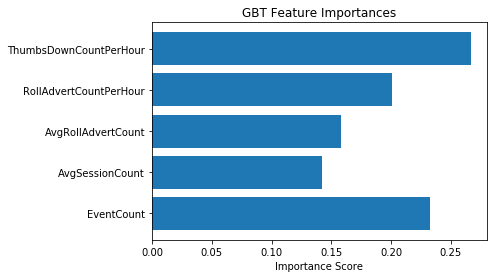

In [338]:
test_gbt(42)

0.7818181818181819
0.7715552739942984


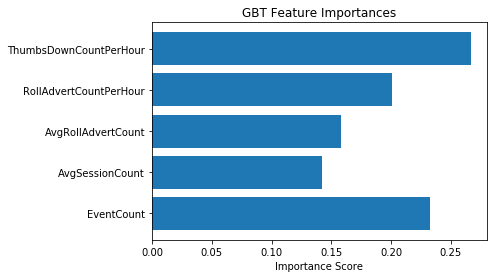

In [322]:
# churn without downgraded users
test_gbt()

0.7090909090909091
0.6954070319923978


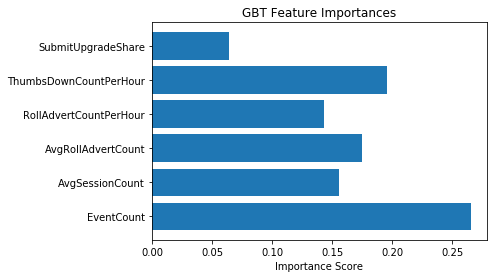

In [303]:
test_gbt()

0.6727272727272727
0.6466533466533466


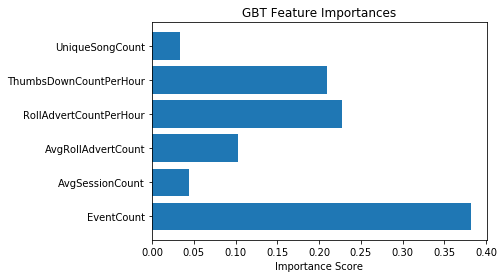

In [282]:
test_gbt()

0.7454545454545455
0.7251748251748252


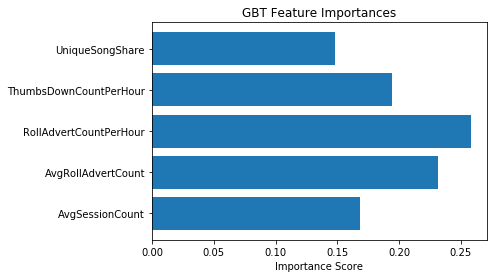

In [268]:
test_gbt()

0.6909090909090909
0.6715995294308545


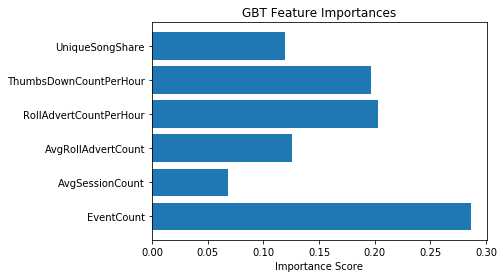

In [258]:
test_gbt()

0.7818181818181819
0.7715552739942984


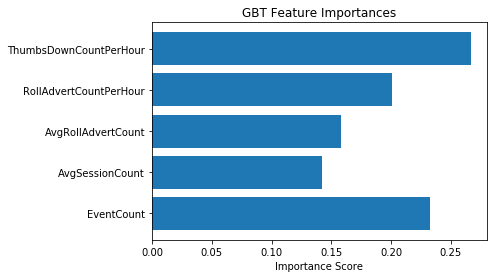

In [241]:
test_gbt()

0.7818181818181819
0.7715552739942984


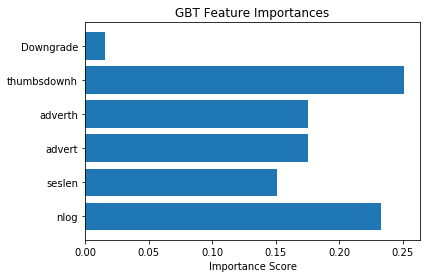

In [175]:
test_gbt()

0.6181818181818182
0.5943288304734088


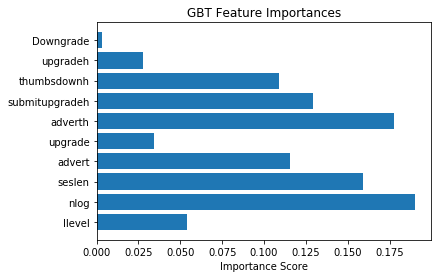

In [164]:
test_gbt()

0.7454545454545455
0.7251748251748252


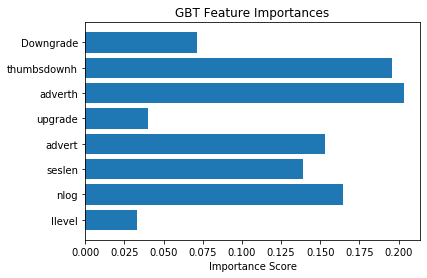

In [151]:
test_gbt()

0.6909090909090909
0.6878800252422139


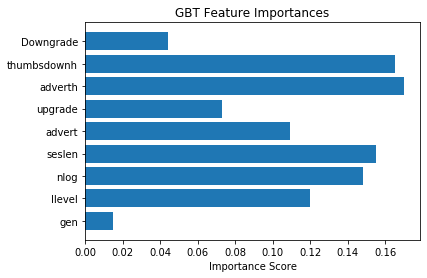

In [139]:
test_gbt()

0.7636363636363637
0.7488702283883006


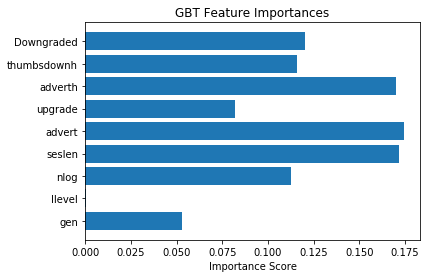

In [119]:
test_gbt()

0.6730769230769231
0.65579133510168


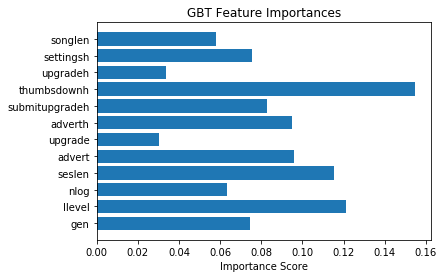

In [721]:
test_gbt()

#### ML

In [619]:
model_data2 = model_data.select('label', 'features')
train,validation = model_data2.randomSplit([0.8, 0.2], seed=42)

In [120]:
# Models to train: logistic regression, svm, gradient boosting tree
logistic_reg = LogisticRegression(maxIter=10, regParam = 0.0)
gbt = GBTClassifier(maxDepth = 5, maxIter = 10, seed = 42)
svm = LinearSVC (maxIter = 10, regParam = 0.01)

##### Logistic Regression

In [121]:
e1 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder() \
    .addGrid(logistic_reg.regParam,[0.0, 0.05, 0.1]) \
    .build()
crossval = CrossValidator(estimator=logistic_reg,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)
cvModel_q1 = crossval.fit(train)
cvModel_q1.avgMetrics

[0.7394105124739777, 0.7473291276605951, 0.7523094613832269]

In [620]:
e1 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder() \
    .addGrid(logistic_reg.regParam,[0.0, 0.05, 0.1]) \
    .build()
crossval = CrossValidator(estimator=logistic_reg,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)
cvModel_q1 = crossval.fit(train)
cvModel_q1.avgMetrics

[0.7757843885075006, 0.7669136403776244, 0.7629631705286708]

##### GBTClassifier

In [621]:
gbt_tuned = GBTClassifier(maxDepth=5, maxIter=10, seed=42)
gbt_model = gbt_tuned.fit(train)
results = gbt_model.transform(validation)

In [622]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

In [623]:
print(evaluator.evaluate(results, {evaluator.metricName: "accuracy"}))

0.7884615384615384


In [624]:
print(evaluator.evaluate(results, {evaluator.metricName: "f1"}))

0.7825724871681565


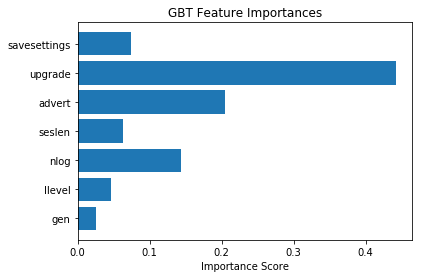

In [625]:
importances = list(gbt_model.featureImportances)
y_pos = np.arange(len(features))
plt.barh(y_pos, importances, align='center')
plt.yticks(y_pos, features)
plt.xlabel('Importance Score')
plt.title('GBT Feature Importances')
plt.savefig('GBT feature Importance.png', dpi=72)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.